In [1]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.01 ms, sys: 171 ms, total: 172 ms
Wall time: 491 ms
CPU times: user 459 µs, sys: 14 ms, total: 14.4 ms
Wall time: 41.7 ms
CPU times: user 1.79 ms, sys: 81.5 ms, total: 83.3 ms
Wall time: 243 ms
CPU times: user 525 µs, sys: 41.7 ms, total: 42.3 ms
Wall time: 128 ms
CPU times: user 431 µs, sys: 5.09 ms, total: 5.53 ms
Wall time: 16.8 ms
CPU times: user 585 µs, sys: 7.37 ms, total: 7.95 ms
Wall time: 23.5 ms
CPU times: user 1.36 ms, sys: 23.8 ms, total: 25.2 ms
Wall time: 72.1 ms


# Load 6x24 MIR features

In [3]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

('x_data_MIR.shape:', (10560, 6, 24))
('x_data_MIR.shape:', (10560, 144))


# Load 32x32 STFT features

In [4]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

('x_data_STFT.shape:', (10560, 32, 32))
('x_data_STFT.shape:', (10560, 1024))


# Load MFCC features

In [5]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

('x_data_MFCC.shape:', (10560, 30, 24))
('x_data_MFCC.shape:', (10560, 720))


# Create ground truth labels

('y_data.shape:', (10560,))


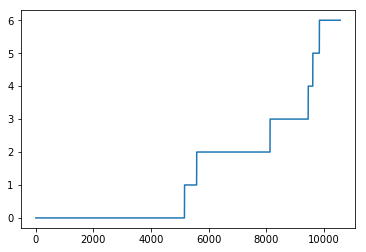

In [6]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Define Kmeans Evaluation

In [7]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

def evalKmeansInit(data_X, data_Y):
    np.random.seed(42)
    data = data_X

    n_samples, n_features = data.shape
    #n_digits = len(np.unique(digits.target))
    n_digits = 7
    labels = data_Y

    sample_size = 300

    print("n_drumtypes: %d, \t n_samples %d, \t n_features %d"
          % (n_digits, n_samples, n_features))

    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    
    bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data, labels = data_Y, sample_size=sample_size)

    bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
                  name="random", data=data, labels = data_Y, sample_size=sample_size)

    # in this case the seeding of the centers is deterministic, hence we run the
    # kmeans algorithm only once with n_init=1
    pca = PCA(n_components=n_digits).fit(data)
    bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
                  name="PCA-based",
                  data=data,
                    labels = data_Y,
                 sample_size=sample_size)
    print(82 * '_')
    
def bench_k_means(estimator, name, data, labels, sample_size):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

### Use Kmeans evaluation on STFT feature set

In [8]:
evalKmeansInit(x_data_STFT, y_data)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 1024
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	8.19s	49845	0.507	0.439	0.470	0.422	0.438	0.214
random   	12.44s	49845	0.508	0.439	0.471	0.421	0.439	0.246
PCA-based	1.66s	49846	0.508	0.439	0.471	0.421	0.439	0.195
__________________________________________________________________________________


### Use Kmeans evaluation on MIR feature set

In [9]:
evalKmeansInit(x_data_MIR, y_data)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 144
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.39s	563026	0.379	0.302	0.336	0.344	0.301	0.140
random   	1.99s	563013	0.378	0.302	0.336	0.344	0.301	0.150
PCA-based	0.28s	577394	0.369	0.277	0.316	0.279	0.276	0.103
__________________________________________________________________________________


### Use Kmeans evaluation on MFCC feature set

In [10]:
evalKmeansInit(x_data_MFCC, y_data)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 720
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	7.53s	2606396979	0.483	0.363	0.414	0.315	0.362	0.175
random   	6.90s	2606361806	0.482	0.362	0.413	0.315	0.361	0.192
PCA-based	0.93s	2606361806	0.482	0.362	0.413	0.315	0.361	0.178
__________________________________________________________________________________


# Plot data in 2D PCA space

In [11]:
def plotPCA2D(data_X, data_Y, title):
    # #############################################################################
    # Visualize the results on PCA-reduced data
    np.random.seed(42)
    data = data_X

    n_samples, n_features = data.shape
    #n_digits = len(np.unique(digits.target))
    n_digits = 7
    labels = data_Y

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='random', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the drumset dataset (Top 2 PCA-reduced data)\n'
              'Centroids are marked with white cross\n' +
                title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Plotting data points in 2D PCA space

### Plotting clustering results using MIR Features

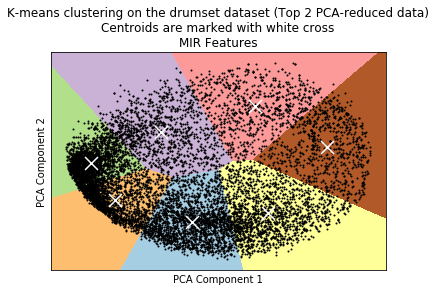

In [12]:
plotPCA2D(x_data_MIR,y_data,"MIR Features")

### Plotting clustering results using STFT Features

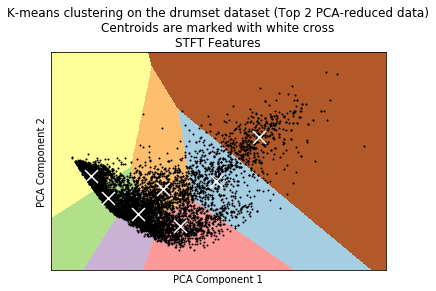

In [13]:
plotPCA2D(x_data_STFT,y_data,"STFT Features")

### Plotting clustering results using MFCC Features

In [ ]:
plotPCA2D(x_data_MFCC,y_data,"MFCC Features")